<a href="https://colab.research.google.com/github/Hurri301/Advanced-Computational-Techniques-for-Big-Imaging-and-Signal-Data/blob/main/lucas_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
import matplotlib.pyplot as plt

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv, src_prefix='spc.'):
        self.df = pd.read_csv(csv, sep=',')
        self.output_cols = ['coarse','clay','silt','sand','pH.in.CaCl2','pH.in.H2O','OC','CaCO3','N','P','K','CEC']
        self.input_cols = [col for col in self.df.columns if col.startswith(src_prefix)]
        x = np.array([float(col[len(src_prefix):]) for col in self.input_cols])
        pos = np.argsort(x)
        self.input_cols = [self.input_cols[cur_pos] for cur_pos in pos]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cur_sample = self.df.iloc[idx]
        cur_sample_x = cur_sample[self.input_cols]
        cur_sample_y = cur_sample[self.output_cols]
        cur_sample_x = torch.tensor(cur_sample_x.tolist())
        cur_sample_y = torch.tensor(cur_sample_y.tolist())
        return cur_sample_x, cur_sample_y


In [23]:
# get validation set
ds = Dataset('/content/drive/MyDrive/lucas_dataset_val.csv')
# get first item
inp, out = ds.__getitem__(0)
# print shapes
print(inp.shape)
print(out.shape)

torch.Size([4200])
torch.Size([12])


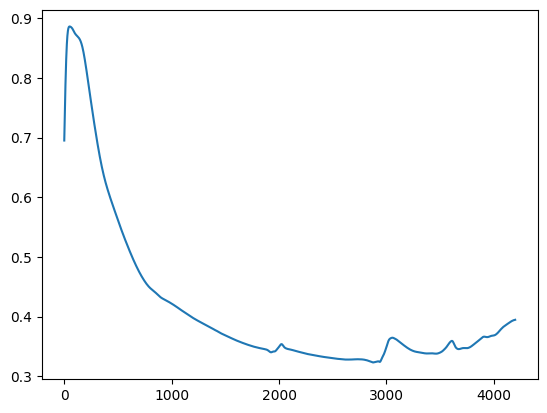

In [24]:
# plot it
plt.plot(inp)
plt.show()

**Define the CNN Model**

In [26]:
class SoilCNN(nn.Module):
    def __init__(self):
        super(SoilCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()

        # Calculate the size after convolution and pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, 4200))  # Dummy forward pass to calculate the output size
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 12)

    def convs(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).size(1)
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
learning_rate = 0.001
batch_size = 16
num_epochs = 10

# Dataset and DataLoader
csv_file = '/content/drive/MyDrive/lucas_dataset_val.csv'
dataset = Dataset(csv_file)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = SoilCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(1).float()
        targets = targets.float()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(1).float()
            targets = targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'soil_cnn_model.pth')


Epoch [1/10], Loss: 6090.9581
Validation Loss: 4842.7170
Epoch [2/10], Loss: 5579.3052
Validation Loss: 4676.0047
Epoch [3/10], Loss: 5362.0971
Validation Loss: 4602.9942
Epoch [4/10], Loss: 5273.8484
Validation Loss: 4468.8465
Epoch [5/10], Loss: 5165.1881
Validation Loss: 4389.0832
Epoch [6/10], Loss: 4996.9138
Validation Loss: 4380.2286
Epoch [7/10], Loss: 4902.5284
Validation Loss: 4255.4884
Epoch [8/10], Loss: 4818.8833
Validation Loss: 4775.8139
Epoch [9/10], Loss: 4810.1021
Validation Loss: 4236.5151
Epoch [10/10], Loss: 4695.0989
Validation Loss: 4195.1645
